In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from itertools import combinations, groupby
from collections import Counter
from collections import OrderedDict
from IPython.display import display
from sklearn import datasets
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
#Import the files
aisles_df = pd.read_csv('aisles.csv')
products_df = pd.read_csv('products.csv')
orders_df = pd.read_csv('orders.csv')
order_products_prior_df = pd.read_csv('order_products__prior.csv')
departments_df = pd.read_csv('departments.csv')
order_products_train_df = pd.read_csv('order_products__train.csv')

In [4]:
prior = pd.read_csv('order_products__prior.csv')
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
orders = pd.read_csv('orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
##Due to the number of rows I have to reduce the set of prior data
prior = prior[0:300000]

In [7]:
order_prior = pd.merge(prior,orders,on=['order_id','order_id'])
order_prior = order_prior.sort_values(by=['user_id','order_id'])
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
221645,23391,13198,1,1,7,prior,17,0,10,28.0
221646,23391,42803,2,1,7,prior,17,0,10,28.0
221647,23391,8277,3,1,7,prior,17,0,10,28.0
221648,23391,37602,4,1,7,prior,17,0,10,28.0
221649,23391,40852,5,1,7,prior,17,0,10,28.0


In [8]:
products = pd.read_csv('products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
aisles = pd.read_csv('aisles.csv')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [10]:
print(aisles.shape)

(134, 2)


In [11]:
_mt = pd.merge(prior,products, on = ['product_id','product_id'])
_mt = pd.merge(_mt,orders,on=['order_id','order_id'])
mt = pd.merge(_mt,aisles,on=['aisle_id','aisle_id'])
mt.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs
5,537,33120,2,1,Organic Egg Whites,86,16,180135,prior,15,2,8,3.0,eggs
6,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.0,eggs
7,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.0,eggs
8,623,33120,1,1,Organic Egg Whites,86,16,37804,prior,63,3,12,3.0,eggs
9,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.0,eggs


In [12]:
mt['product_name'].value_counts()[0:10]

Banana                    4432
Bag of Organic Bananas    3563
Organic Strawberries      2370
Organic Baby Spinach      2242
Organic Hass Avocado      1985
Organic Avocado           1626
Large Lemon               1380
Strawberries              1343
Organic Raspberries       1293
Limes                     1270
Name: product_name, dtype: int64

In [13]:
len(mt['product_name'].unique())

24836

In [14]:
prior.shape

(300000, 4)

In [15]:
#Clustering Customers
#We are dealing with 161 types of product (aisle).
len(mt['aisle'].unique())

134

In [16]:
#Fresh fruits and fresh vegetables are the best selling goods.
mt['aisle'].value_counts()[0:10]

fresh fruits                     33755
fresh vegetables                 31004
packaged vegetables fruits       16319
yogurt                           13477
packaged cheese                   9133
milk                              8254
water seltzer sparkling water     7634
chips pretzels                    6581
soy lactosefree                   5965
bread                             5457
Name: aisle, dtype: int64

In [17]:
cust_prod = pd.crosstab(mt['user_id'], mt['aisle'])
cust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,4
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4
36,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
cust_prod.shape

(25831, 134)

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)

In [20]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5,6
0,-0.286251,1.005868,-1.030293,-0.898963,-0.587648,-0.998880,0.329980
1,-1.972748,-0.487659,-0.120542,0.213078,0.046009,-0.181825,-0.168180
2,-1.168974,1.284089,3.228124,0.594050,-0.648848,-1.091898,0.941541
3,-1.433967,1.250081,3.261985,1.237737,-0.353520,-0.346474,0.812611
4,-2.070709,-0.422148,-0.101552,0.278139,0.005931,-0.097236,0.025040


(25831, 2)
          5         1
0 -0.998880  1.005868
1 -0.181825 -0.487659
2 -1.091898  1.284089
3 -0.346474  1.250081
4 -0.097236 -0.422148


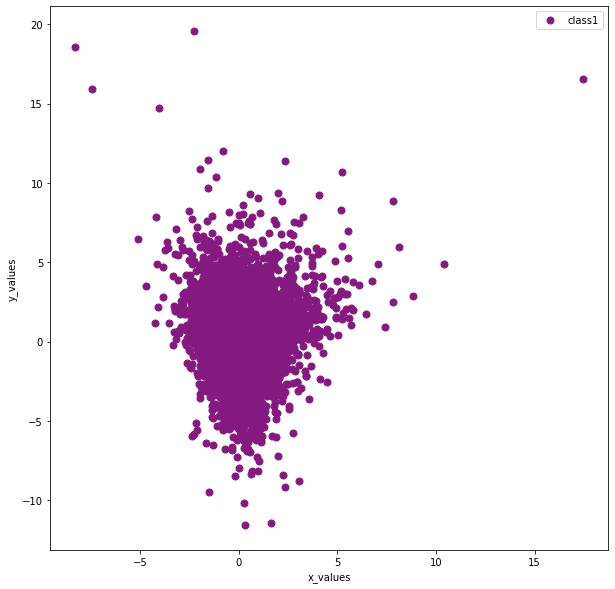

In [21]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
tocluster = pd.DataFrame(ps[[5,1]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(10,10))
plt.plot(tocluster[5], tocluster[1], 'o', markersize=7, color='#841a7f', alpha=1, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

# K-Means Clustering Algorithm

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=5,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[-0.45977587  1.16464177]
 [ 0.16251895  3.87927525]
 [ 1.24179354  0.5135235 ]
 [-0.13481898 -0.36794823]
 [ 0.10341188 -2.47977422]]


In [23]:
print (c_preds[0:150])

[0 3 0 0 3 3 3 3 3 3 4 2 0 3 3 0 2 3 0 3 3 3 3 3 3 0 4 3 3 1 0 3 2 3 3 0 3
 3 3 3 0 3 3 3 3 3 3 3 0 3 3 3 0 3 3 3 0 3 3 3 4 3 3 3 0 3 3 3 4 3 3 3 3 0
 0 2 4 3 0 3 2 3 0 0 3 2 4 0 3 3 2 3 3 1 3 3 0 2 2 3 0 4 3 3 0 0 3 3 3 2 3
 2 3 3 2 1 2 3 3 3 0 2 3 2 3 2 3 2 3 0 4 3 3 2 0 3 0 0 3 3 0 3 0 1 4 4 0 2
 0 3]


['#151cef', 'green', '#151cef', '#151cef', 'green', 'green', 'green', 'green', 'green', 'green']


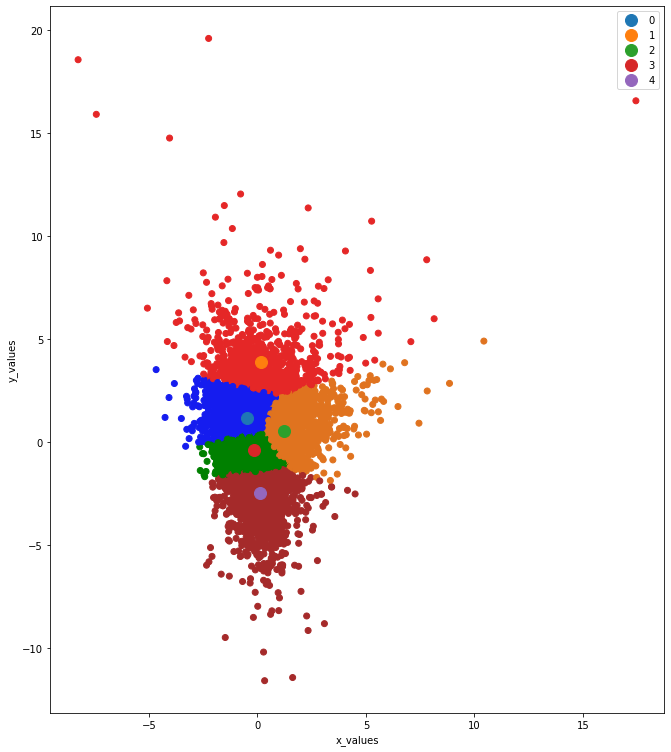

In [24]:
#Here is how our clusters appear
import matplotlib
fig = plt.figure(figsize=(11,13))
colors = ['#151cef','#e52727','#e0731f','green','brown']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[5],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=12,alpha=1, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [25]:
print(classification_report(ps,clusterer))

TypeError: Expected sequence or array-like, got estimator KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [26]:
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA 

In [27]:
# Scaling the data to bring all the attributes to a comparable level 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(cust_prod) 

# Normalizing the data so that 
# the data approximately follows a Gaussian distribution 
X_normalized = normalize(X_scaled) 

# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_normalized) 

In [28]:
# Numpy array of all the cluster labels assigned to each data point 
pca = PCA(n_components = 2) 
random = pca.fit_transform(cust_prod) 
random = pd.DataFrame(random) 
random.columns = ['P1', 'P2'] 
print(random.head()) 

         P1        P2
0 -0.286251  1.005868
1 -1.972748 -0.487659
2 -1.168974  1.284089
3 -1.433967  1.250081
4 -2.070709 -0.422148


In [29]:
db_default = DBSCAN(eps = 1, min_samples = 3).fit(random) 
labels = db_default.labels_ 

In [30]:
from sklearn import metrics

#identifying the points which makes up our core points
sample_cores=np.zeros_like(labels,dtype=bool)

sample_cores[db_default.core_sample_indices_]=True

#Calculating the number of clusters

n_clusters=len(set(labels))- (1 if -1 in labels else 0)

In [31]:
print(metrics.silhouette_score(cust_prod,labels))

0.7158520286947498


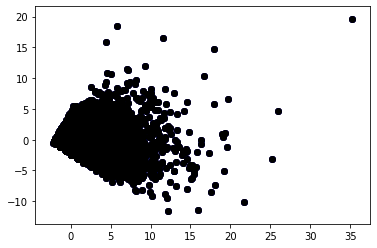

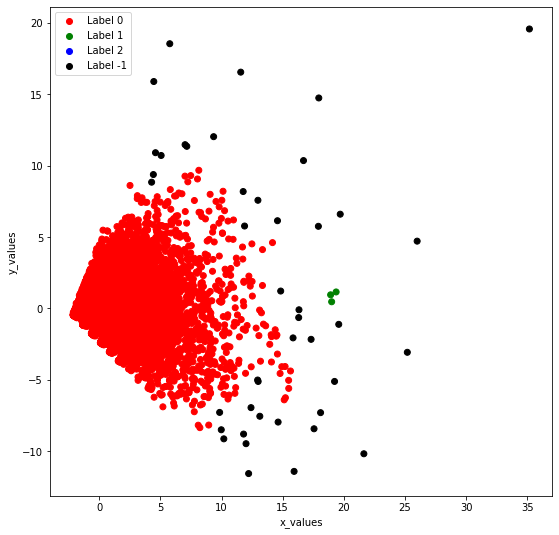

In [32]:
# Building the label to colour mapping 
colours = {} 
colours[0] = 'r'
colours[1] = 'g'
colours[2] = 'b'
colours[-1] = 'k'

# Building the colour vector for each data point 
cvec = [colours[label] for label in labels] 

# For the construction of the legend of the plot 
r = plt.scatter(random['P1'], random['P2'], color ='r'); 
g = plt.scatter(random['P1'], random['P2'], color ='g'); 
b = plt.scatter(random['P1'], random['P2'], color ='b'); 
k = plt.scatter(random['P1'], random['P2'], color ='k'); 

# Plotting P1 on the X-Axis and P2 on the Y-Axis 
# according to the colour vector defined 
plt.figure(figsize =(9, 9)) 
plt.scatter(random['P1'], random['P2'], c = cvec) 
plt.xlabel('x_values')
plt.ylabel('y_values')
# Building the legend 
plt.legend((r,g,b,k), ('Label 0', 'Label 1', 'Label 2', 'Label -1')) 

plt.show() 

In [34]:
print(classification_report(ps,cust_prod))

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass-multioutput targets